# Yelp Reviews
The dataset can be found here: https://www.kaggle.com/yelp-dataset/yelp-dataset/notebooks?datasetId=10100&sortBy=dateRun

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os

%matplotlib inline
import matplotlib

Checking to make sure I have GPU support for TensorFlow

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
tf.version.VERSION
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Importing the Data
Here, I'm going to import all of the paths to all of the files into a list. The files are all in the parent directory of the current working directory. So to get the base_dir, I need to join the cwd with the pardir. Then, I dynamically retrieve all of the files in just that directory, join the root with the file name, and append that to the list all_files.

In [4]:
all_files = []

base_dir = os.path.join(os.getcwd(), os.pardir)
for count, (root, dirs, files) in enumerate(os.walk(base_dir)):
    if (count == 0):
        for file in files:
            all_files.append(os.path.join(root, file))
all_files

['C:\\Users\\lhm\\GitHub\\yelp_reviews\\yelp_reviews\\..\\Dataset_Agreement.pdf',
 'C:\\Users\\lhm\\GitHub\\yelp_reviews\\yelp_reviews\\..\\yelp_academic_dataset_business.json',
 'C:\\Users\\lhm\\GitHub\\yelp_reviews\\yelp_reviews\\..\\yelp_academic_dataset_checkin.json',
 'C:\\Users\\lhm\\GitHub\\yelp_reviews\\yelp_reviews\\..\\yelp_academic_dataset_review.json',
 'C:\\Users\\lhm\\GitHub\\yelp_reviews\\yelp_reviews\\..\\yelp_academic_dataset_tip.json',
 'C:\\Users\\lhm\\GitHub\\yelp_reviews\\yelp_reviews\\..\\yelp_academic_dataset_user.json']

In order to read the data, from version 0.19.0 of Pandas and later, it is necessary to use the lines parameter. This tells pandas to read it line by line. There might be some faster ways of loading this into memory, since this does take a few minutes to fully load.

This could possibly be done by passing the chunksize argument into pd.read_json. Or I could possibly try reading the JSON file directly as a JSON object (into a Python dictionary) then use the json module. More details on these can be found here:https://datascience.stackexchange.com/questions/60268/load-large-jsons-file-into-pandas-dataframe

In [5]:
import json
#data = json.load(open(all_files[3],"r"))
#review = pd.DataFrame.from_dict(data, orient="index")
#business = pd.read_json(all_files[1], lines=True)
#checkin = pd.read_json(all_files[2], lines=True)
review = pd.read_json(all_files[3], lines=True) #, chunksize = 10)
#tip = pd.read_json(all_files[4], lines=True)
#user = pd.read_json(all_files[5], lines=True)

In [6]:
review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2,5,0,0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1,1,1,0,I am actually horrified this place is still in...,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5,1,0,0,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1,0,0,0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4,0,0,0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57


Here is an example review:

In [7]:
review['text'][0]

'As someone who has worked with many museums, I was eager to visit this gallery on my most recent trip to Las Vegas. When I saw they would be showing infamous eggs of the House of Faberge from the Virginia Museum of Fine Arts (VMFA), I knew I had to go!\n\nTucked away near the gelateria and the garden, the Gallery is pretty much hidden from view. It\'s what real estate agents would call "cozy" or "charming" - basically any euphemism for small.\n\nThat being said, you can still see wonderful art at a gallery of any size, so why the two *s you ask? Let me tell you:\n\n* pricing for this, while relatively inexpensive for a Las Vegas attraction, is completely over the top. For the space and the amount of art you can fit in there, it is a bit much.\n* it\'s not kid friendly at all. Seriously, don\'t bring them.\n* the security is not trained properly for the show. When the curating and design teams collaborate for exhibitions, there is a definite flow. That means visitors should view the ar

## Engineering the Label
For this dataset, I want to simplify it down so that it just contains the text and labels. Specifically, I want to use NLP in order to identify whether a review is positive or negative. In order to do this, I'm going to engineer a new label called "target" which is 1 when the review received 4 or 5 stars and is 0 when the review received 1 or 2 stars. I'm going to ignore 3 star reviews since those would be neutral.

For this project, I will only need the label and the review. The other columns won't be necessary.

In [8]:
review = review[['review_id','stars','text']]
review = review.copy(deep=True)

In [9]:
review['label'] = review['stars'].map({5:'1',4:'1',2:'0',1:'0'})

In [10]:
review = review[review['label'].notnull()]

In [11]:
review2 = review

In [12]:
review.reset_index(drop=True, inplace = True)

Since there is so much data, I'm going to throw out 80% of it. This is primarily because the number of records is very high and I want to save computation time. That way I'll be working with 1.4 million records instead of 7.2 million records. I'm sure this could have an impact on the final accuracy of the model, but I think 1.4 million records is more than enough.

In [13]:
review_size = review.shape[0]
review = review.loc[0:review_size*0.2,['text','label']]

In [14]:
review_size

7178833

In [15]:
review.shape[0]

1435767

## Splitting the Data into train, cv, and test
Before doing anything else. I'm going to split the data into a training, cv, and test set. I'm doing this before even running the tokenizer in order to avoid data leakage. Data leakage is when information from outside the training dataset is used to create the model. If I even ran the tokenizer before separating out the training and test set, then the AI would have knowledge of the words that were used in the test set and would be able to assign them numbers in the tokenizer.

In [16]:
train_size = int(review.shape[0] * 0.7)
cv_size = int(review.shape[0] * 0.2)

In [17]:
train = review['text'][0:train_size]
cv = review['text'][train_size:train_size+cv_size]
test = review['text'][train_size + cv_size :]

train_y = review['label'][0:train_size]
cv_y = review['label'][train_size:train_size+cv_size]
test_y = review['label'][train_size + cv_size :]

In [92]:
type(train)

pandas.core.series.Series

In [18]:
train.shape

(1005036,)

In [19]:
cv.shape

(287153,)

In [20]:
test.shape

(143578,)

In [22]:
X = train.values
y = train_y.values

In [89]:
X[0]

'As someone who has worked with many museums, I was eager to visit this gallery on my most recent trip to Las Vegas. When I saw they would be showing infamous eggs of the House of Faberge from the Virginia Museum of Fine Arts (VMFA), I knew I had to go!\n\nTucked away near the gelateria and the garden, the Gallery is pretty much hidden from view. It\'s what real estate agents would call "cozy" or "charming" - basically any euphemism for small.\n\nThat being said, you can still see wonderful art at a gallery of any size, so why the two *s you ask? Let me tell you:\n\n* pricing for this, while relatively inexpensive for a Las Vegas attraction, is completely over the top. For the space and the amount of art you can fit in there, it is a bit much.\n* it\'s not kid friendly at all. Seriously, don\'t bring them.\n* the security is not trained properly for the show. When the curating and design teams collaborate for exhibitions, there is a definite flow. That means visitors should view the ar

## Fitting the Tokenizer
Tokenization is the task of chopping the data into pieces called tokens. These tokens can be letters, subwords, or words. In this case, I am tokenizing by words. I pass num_words = 10000, which means that the tokenizer will only convert the top 10,000 words to their token when calling texts_to_sequences and any other word that is out of the 10,000 word vocabulary will be given the oov_token, which is 1. Also, I filter out the punctuation and convert all of the words to lower case.

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
tokenizer = Tokenizer(oov_token="<OOV>", 
                      num_words = vocab_size, 
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True)
tokenizer.fit_on_texts(X)

In [26]:
## Named list mapping words to number of times they appeared on during fit
#tokenizer.word_counts

## Named list mapping words to the number of documents/texts they appeared on during fit
#tokenizer.word_docs

## Named list mapping words to their rank/index (int)
#tokenizer.word_index

## Number of documents the tokenizer was trained on
#tokenizer.document_count

Although I set the tokenizer num_words hyperparemeter to 10,000, the tokenizer still keeps track of the counter on all words. That is why the tokenizer.word_index contains 260,000+ words. However, the tokenizer only uses the num_words most common words when any transformative method is called though. The reason it behaves like this is so that a user can call fit_on_texts multiple times. Each time it will update the internal counters, and when transformations are called, it will use the top words based on the updated counters.

In [27]:
word_index = tokenizer.word_index
print(len(word_index))

268819


Since the average length of a review in the training set is a little bit lower than 580, I'm going to pad all of the sequences that are shorter than 580 so that they are are of length 580 using padding_type = 'post'. Any sequences that are longer 580 that will be truncated from the end.

In [93]:
average_length_of_text = train.apply(len).mean()
print("Average length of review: " + str(average_length_of_text))

Average length of review: 573.2050016118826


In [28]:
trunc_type='post'
max_length = 580
padding_type='post'
embedding_dim = 16
vocab_size = 10000

In [29]:
sequences = tokenizer.texts_to_sequences(X)

In [30]:
sequences_padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

Here I can see that the pad_sequences worked. This shows that each dimension has 580 elements.

In [31]:
print(sequences_padded.shape)

(1005036, 580)


In [32]:
validation_sequences = tokenizer.texts_to_sequences(cv)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [33]:
print(validation_padded.shape)

(287153, 580)


## Creating a neural network with a Conv1D layer
I'm going to try 2 different types of neural networks. I'll try a neural network with a convolutional layer, and I'll also try a neural network with a bidirectional LSTM layer.

For this neural network, the input layer is an embedding layer, followed by a 1D convolutional layer, a global average pooling layer, and a dense layer. 

In [119]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [120]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 580, 16)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 576, 128)          10368     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 178,689
Trainable params: 178,689
Non-trainable params: 0
_________________________________________________________________


In [34]:
sequences_padded = np.array(sequences_padded)
y = np.array(y).astype('float')
validation_padded = np.array(validation_padded)
cv_y = np.array(cv_y).astype('float')

## Training
This neural network trained relatively quickly. I only trained it for 3 epochs since the cross validation accuracy increased all the way to 97.3% in the third epoch.

In [122]:
num_epochs = 3
history = model.fit(sequences_padded, y, epochs=num_epochs, validation_data=(validation_padded, cv_y))

Epoch 1/3
31408/31408 [==============================] - 237s 7ms/step - loss: 0.1391 - accuracy: 0.9452 - val_loss: 0.0863 - val_accuracy: 0.9676
Epoch 2/3
31408/31408 [==============================] - 232s 7ms/step - loss: 0.0768 - accuracy: 0.9718 - val_loss: 0.0755 - val_accuracy: 0.9722
Epoch 3/3
31408/31408 [==============================] - 235s 7ms/step - loss: 0.0644 - accuracy: 0.9765 - val_loss: 0.0728 - val_accuracy: 0.9734


## Analysis of Training Data
Here, I can see that the accuracy and val_accuracy increased for all 3 epochs. The validation accuracy leveled off after the 2nd epoch. There is a similar trend with the loss graph where the val_loss leveled off too after the 2nd epoch.

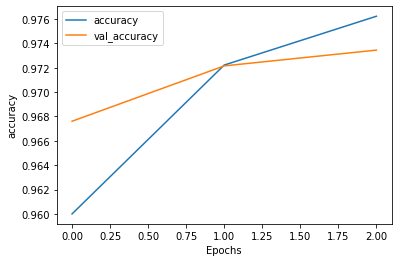

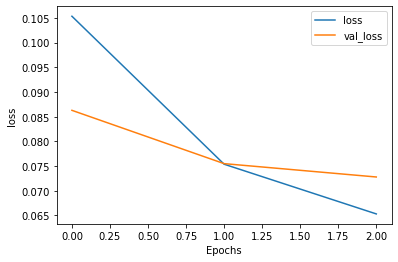

In [123]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history,"loss")

## Creating a neural network with a bidirectional LSTM layer and Dropout layer
For the next neural network, I tried a bidirectional LSTM layer.

In [35]:
from tensorflow.keras.layers import Bidirectional, LSTM

In [36]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 580, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 174,657
Trainable params: 174,657
Non-trainable params: 0
_________________________________________________________________


## Training the Neural Network
Training this neural network took a long time, even though I only trained for 3 epochs. However, the accuracy was slightly higher than the convolutional neural network. Here, the cross validation accuracy increased to 97.53% instead of 97.34%.

In [37]:
num_epochs = 3
history2 = model2.fit(sequences_padded, y, epochs=num_epochs, validation_data=(validation_padded, cv_y))

Epoch 1/3
31408/31408 [==============================] - 1222s 39ms/step - loss: 0.1654 - accuracy: 0.9391 - val_loss: 0.0846 - val_accuracy: 0.9700
Epoch 2/3
31408/31408 [==============================] - 1239s 39ms/step - loss: 0.0824 - accuracy: 0.9709 - val_loss: 0.0712 - val_accuracy: 0.9739
Epoch 3/3
31408/31408 [==============================] - 1213s 39ms/step - loss: 0.0671 - accuracy: 0.9759 - val_loss: 0.0674 - val_accuracy: 0.9753


## Analysis of Training Data
Here, I can see that the accuray and loss for both did not level out after the 2nd epoch like in the first neural net. The accuracy ended up very close to the val_accuracy, and the loss ended up very close to the val_loss.

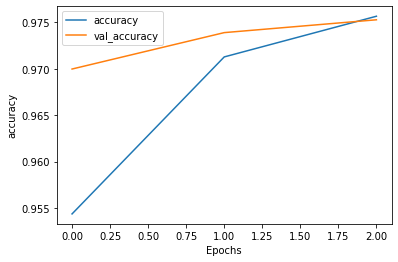

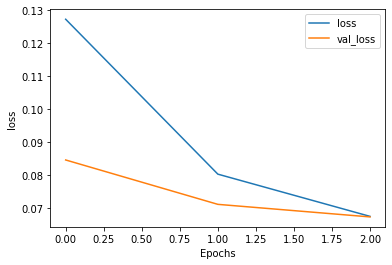

In [39]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history2, "accuracy")
plot_graphs(history2,"loss")

## Test the Accuracy of the Model on the Hold Out Set
Up until now, I have not checked the accuracy of the model on the hold out 'test' set. First I will need to preprocess the series to get it into the correct format to feed into the neural net. First, I need to convert the text into a sequence of numbers using the tokenizer. Next, I will need to pad/truncate the sequences so that they are all of the correct length. Then I can feed the data into the model to make predictions.

I'll be checking the accuracy of the LSTM neural network.

In [55]:
test_sequences = tokenizer.texts_to_sequences(test)
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [83]:
test_predictions = model2.predict(x = test_sequences_padded)

In [84]:
test_predictions[:3]

array([[0.996009 ],
       [0.187874 ],
       [0.9960497]], dtype=float32)

The final layer contains a single neuron with the sigmoid activation function. This means that all of the predictions are made as a floating point number between 0 to 1. But I want to change this into binary 'positive' or 'negative' so I'm going to convert the test_predictions array into a DataFrame and then apply a function to convert it to binary. Any prediction less than 0.5 will be 0 and any prediction greater than or equal to 0.5 will be converted to 1.

In [74]:
test_predictions = pd.DataFrame(test_predictions)

In [75]:
def convert_to_binary(row):
        if(row[0] < 0.5):
            return 0
        else:
            return 1

In [76]:
test_predictions_binary = test_predictions.apply(convert_to_binary, axis=1)

In [85]:
test_predictions_binary.head(3)

0    1
1    0
2    1
dtype: int64

For the true values, I need to cast them as type int64 since they were initially of object type.

In [78]:
test_y = test_y.astype('int64')

## Accuracy on Test Set
Finally I can get the accuracy score using sklearn.metrics accuracy_score. The model had 97.7% accuracy at differentiating between positive and negative reviews after only training on 20% of the available data. I'm surprised that the neural network was able to perform so well. At first when embarking on this project, I didn't think that the NN would be able to so easily differentiate between a positive and a negative review. After thinking about it, it makes sense that maybe the positive reviews generally used the same language that the NN was able to pick up on. And vice versa with the negative reviews.

In [79]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y, test_predictions_binary)

0.976841855994651